# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, auc
from scipy.stats import ks_2samp

import statsmodels.formula.api as smf

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
def analise_bivariada(dataframe: pd.DataFrame, var_resposta: str, var_explicativa: str) -> pd.DataFrame:    
    gp = dataframe.groupby(by=var_explicativa).agg(
        count_varR_True=(var_resposta, lambda x: x[x == 1].count()),
        count_varR_False=(var_resposta, lambda x: x[x == 0].count()),
        count_varR=(var_resposta, 'count'),
        mean_varR=(var_resposta, 'mean')
    )
    
    gp['odd_True'] = gp['count_varR_True'] / gp['count_varR_False']
    gp['odd_False'] = gp['count_varR_False'] / gp['count_varR_True']
    gp['ratio_True'] = gp['odd_True'] * (gp['count_varR_True'] / gp['count_varR']) ** -1
    gp['ratio_False'] = gp['odd_False'] * (gp['count_varR_False'] / gp['count_varR']) ** -1
    gp['logito_True'] = np.log(gp['odd_True'])
    gp['woe_True'] = np.log(gp['ratio_True'])
    gp['woe_False'] = np.log(gp['ratio_False'])

    return gp

In [5]:
gp_cp = analise_bivariada(df, 'flag_doente', 'cp')
gp_cp

,count_varR_True,count_varR_False,count_varR,mean_varR,odd_True,odd_False,ratio_True,ratio_False,logito_True,woe_True,woe_False
cp,,,,,,,,,,,
1.0,7,16,23,0.304348,0.437500,2.285714,1.437500,3.285714,-0.826679,0.362905,1.189584
2.0,9,41,50,0.180000,0.219512,4.555556,1.219512,5.555556,-1.516347,0.198451,1.714798
3.0,18,68,86,0.209302,0.264706,3.777778,1.264706,4.777778,-1.329136,0.234840,1.563976
4.0,105,39,144,0.729167,2.692308,0.371429,3.692308,1.371429,0.990399,1.306252,0.315853


In [6]:
gp_fbs = analise_bivariada(df, 'flag_doente', 'fbs')
gp_fbs

,count_varR_True,count_varR_False,count_varR,mean_varR,odd_True,odd_False,ratio_True,ratio_False,logito_True,woe_True,woe_False
fbs,,,,,,,,,,,
0.0,117,141,258,0.453488,0.829787,1.205128,1.829787,2.205128,-0.186586,0.604200,0.790786
1.0,22,23,45,0.488889,0.956522,1.045455,1.956522,2.045455,-0.044452,0.671168,0.715620


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [7]:
gp_restecg = analise_bivariada(df, 'flag_doente', 'restecg')
gp_restecg

,count_varR_True,count_varR_False,count_varR,mean_varR,odd_True,odd_False,ratio_True,ratio_False,logito_True,woe_True,woe_False
restecg,,,,,,,,,,,
0.0,56,95,151,0.370861,0.589474,1.696429,1.589474,2.696429,-0.528525,0.463403,0.991928
1.0,3,1,4,0.750000,3.000000,0.333333,4.000000,1.333333,1.098612,1.386294,0.287682
2.0,80,68,148,0.540541,1.176471,0.850000,2.176471,1.850000,0.162519,0.777705,0.615186


Analisando os dataframes acima, a classe que mais se destaca na sua capacidade de discriminação dos valores de doentes (True) e saudáveis (False) é a classe 1.0 da variável **restecg**, contudo, essa varíavel tem muito pouco observações (4 amostras) para ter relevância. Levando em consideração que a variável mais interessante deve ser aquela que:
- A) Possui o maior número de observações
- B) Possui o maior valor do logito

Então a nossa variável de interesse das três vistas acima seria a variável **cp**, especificamente a classe 4.0, pois essa possui o maior número de amostras aliado ao maior valor de logito.

Vale ressaltar que, a análise dos dataframes parecem revelar uma maior relevância da variável **cp**, contudo, será necessário análises por outros pontos de vista antes que a variável possa ser, de fato, considerada relevante.

3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [8]:
regL = smf.logit('flag_doente ~ sex + cp + trestbps + age', data=df).fit()
regL.summary()

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Wed, 07 Aug 2024   Pseudo R-squ.:                  0.2605
Time:                        22:05:16   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex            1.8021      0.331      5.444      0.000       1.153       2.451
cp             1.1403      0.169      6.739      0.000       0.809       1.472
trestbps       0.0214      0.008      2.600      0.009       0.005       0.037
age            0.0582      0.017      3.348      0.001       0.024       0.092
==============================================================================
"""

Analisando a regressão acima, podemos concluir que as variáveis usadas são de relevância ao modelo, confirmando a análise anterior de que a variável **cp** tem relevância para o modelo.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor esperado versus observado para a taxa de maus por grupo

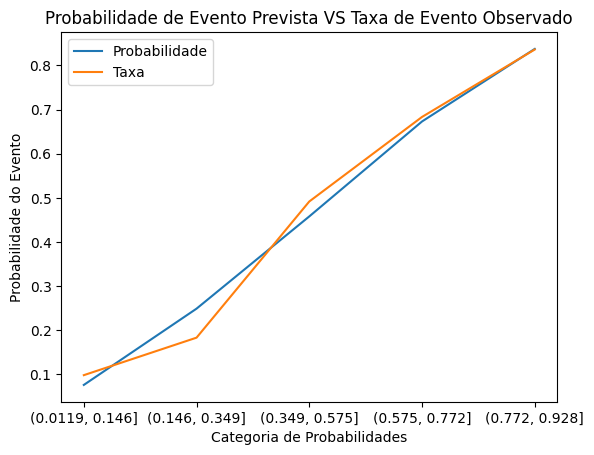

In [9]:
data = df.copy()

data['probEvento'] = regL.predict(data[['sex', 'cp', 'trestbps', 'age']])
data['cat_probEvento'] = pd.qcut(data['probEvento'], 5)

gp = data.groupby('cat_probEvento', observed=True).agg(
    prob_mediaEvento=('probEvento', 'mean'),
    taxaEvento=('flag_doente', 'mean')
)

fig, ax = plt.subplots()

ax.set_title('Probabilidade de Evento Prevista VS Taxa de Evento Observado')
ax.set_xlabel('Categoria de Probabilidades')
ax.set_ylabel('Probabilidade do Evento')

sns.lineplot(x=[str(item) for item in gp.reset_index()['cat_probEvento']], y=gp['prob_mediaEvento'], label='Probabilidade', ax=ax)
sns.lineplot(x=[str(item) for item in gp.reset_index()['cat_probEvento']], y=gp['taxaEvento'], label='Taxa')

plt.show()

Como podemos observar acima, o modelo se mostrou suficientemente consistente na sua calibragem comparado com a taxa real dos eventos observados.

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [10]:
data['predict'] = round(data['probEvento']).astype(np.int64)
acuracia = accuracy_score(data['flag_doente'], data['predict'])
false_positive_rate, true_positive_rate, thresholds = roc_curve(data['flag_doente'], data['predict'])
auc_ = auc(false_positive_rate, true_positive_rate)
gini = 2 * auc_ - 1
ks = ks_2samp(data.loc[data['flag_doente'] == 1, 'predict'], data.loc[data['flag_doente'] != 1, 'predict']).statistic

print('Acurácia: {:.2f}%\nAUC: {:.2f}%\nGINI: {:.2f}%\nKS: {:.2f}%'.format(acuracia*100, auc_*100, gini*100, ks*100))

Acurácia: 77.89%
AUC: 77.76%
GINI: 55.53%
KS: 55.53%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [29]:
regL2 = smf.logit('flag_doente ~ 0 + sex + cp + trestbps + restecg + thalach + exang', data=df).fit()
regL2.summary()

Optimization terminated successfully.
         Current function value: 0.457903
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      297
Method:                           MLE   Df Model:                            5
Date:                Wed, 07 Aug 2024   Pseudo R-squ.:                  0.3361
Time:                        22:10:39   Log-Likelihood:                -138.74
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.406e-28
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sex            1.6184      0.341      4.741      0.000       0.949       2.287
cp             0.6914      0.156      4.422      0.000       0.385       0.998
trestbps       0.0165      0.007      2.498      0.012       0.004       0.029
restecg        0.3062      0.151      2.021      0.043       0.009       0.603
thalach       -0.0419      0.006     -6.502      0.000      -0.055      -0.029
exang          1.0435      0.345      3.021      0.003       0.366       1.721
==============================================================================
"""

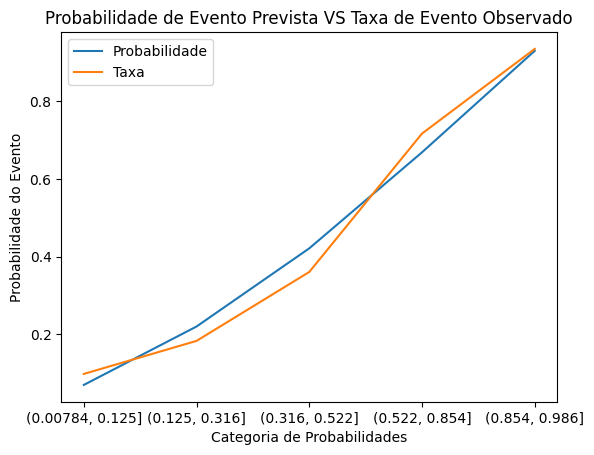

In [30]:
data['probEvento'] = regL2.predict(data[['sex', 'cp', 'trestbps', 'restecg', 'thalach', 'exang']])
data['cat_probEvento'] = pd.qcut(data['probEvento'], 5)

gp = data.groupby('cat_probEvento', observed=True).agg(
    prob_mediaEvento=('probEvento', 'mean'),
    taxaEvento=('flag_doente', 'mean')
)

fig, ax = plt.subplots()

ax.set_title('Probabilidade de Evento Prevista VS Taxa de Evento Observado')
ax.set_xlabel('Categoria de Probabilidades')
ax.set_ylabel('Probabilidade do Evento')

sns.lineplot(x=[str(item) for item in gp.reset_index()['cat_probEvento']], y=gp['prob_mediaEvento'], label='Probabilidade', ax=ax)
sns.lineplot(x=[str(item) for item in gp.reset_index()['cat_probEvento']], y=gp['taxaEvento'], label='Taxa')

plt.show()

In [31]:
data['predict'] = round(data['probEvento']).astype(np.int64)
acuracia = accuracy_score(data['flag_doente'], data['predict'])
false_positive_rate, true_positive_rate, thresholds = roc_curve(data['flag_doente'], data['predict'])
auc_ = auc(false_positive_rate, true_positive_rate)
gini = 2 * auc_ - 1
ks = ks_2samp(data.loc[data['flag_doente'] == 1, 'predict'], data.loc[data['flag_doente'] != 1, 'predict']).statistic

print('Acurácia: {:.2f}%\nAUC: {:.2f}%\nGINI: {:.2f}%\nKS: {:.2f}%'.format(acuracia*100, auc_*100, gini*100, ks*100))

Acurácia: 79.87%
AUC: 79.48%
GINI: 58.97%
KS: 58.97%


O segundo modelo criado tem parâmetros melhores do que o primeiro modelo, com uma diferença na acurácia de quase 2%, no entanto, a calibragem do modelo parece ter visualmente piorado, o que pode indicar que o novo modelo não seja tão eficiente quanto o modelo anterior.

Em última instância, seria necessário observar outros parâmetros e hiper-parâmetros dos dois modelos para determinar qual deles tem o melhor trade-off em acurácia e calibragem.